# Predicting Type of Chest Pain Using Age, Serum Cholesterol Levels, Resting Blood Pressure and Maximum Heart Rate as Predictors

  Heart disease is the leading cause of death across the world, account for 1 in 6 deaths. Angina, any chest pain caused by reduced blood flow to the heart, is a warning sign for risk of heart attack and stroke. Risk factors for heart disease are thus related to the experience of anginal pain due to reduced blood flow to the heart. Elevated cholesterol levels result in plaque build up in arterial walls known as atherosclerosis. This build up causes arteries to narrow, restricting blood flow to the heart. Resting blood pressure and maximum heart rate are both directly proportional to how much blood is pumped and therefore, how much blood is flown through to the heart. 
  
  We will be using a classification model to answer the predictive question of whether we can use the analysis of age, serum cholesterol levels, resting blood pressure and maximum heart rate of the patient to predict what type of chest pain the patient is experiencing.  The dataset we are using has heart disease data from Cleveland Clinic Foundation retrieved from the web. The dataset contains 14 variables including age, sex, type of chest pain, resting blood pressure, serum cholesterol, fasting blood sugar, resting ECG, maximum heart rate achieved, exercise induced angina, ST depression induced by exercise, slope of peak exercise segment, number of major vessels, defect, and angiographic disease status. It was processed from a larger data set containing 76 raw attributes but only 14 were deemed useful. 

In [20]:
#Reading dataset from web into R
library(tidyverse)
library(readr)
library(tidymodels)
set.seed(1)
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
cleveland_data <- read_csv(url, col_names = c("Age", "Sex", "Chest_Pain", "Rest_BP",
                                             "Cholesterol", "Fast_BS", "Rest_ECG", 
                                             "Max_HR", "Ex_Angina", "ST_Dep", "Slope",
                                             "Vessels", "Thal", "Disease_Presence")) |>
mutate(Chest_Pain = as_factor(Chest_Pain))
cleveland_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): Vessels, Thal
dbl (12): Age, Sex, Chest_Pain, Rest_BP, Cholesterol, Fast_BS, Rest_ECG, Max...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Age,Sex,Chest_Pain,Rest_BP,Cholesterol,Fast_BS,Rest_ECG,Max_HR,Ex_Angina,ST_Dep,Slope,Vessels,Thal,Disease_Presence
<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0
62,0,4,140,268,0,2,160,0,3.6,3,2.0,3.0,3
57,0,4,120,354,0,0,163,1,0.6,1,0.0,3.0,0
63,1,4,130,254,0,2,147,0,1.4,2,1.0,7.0,2


In [21]:
cleveland_split <- initial_split(cleveland_data, prop = 0.75, strata = Chest_Pain)
cleveland_train <- training(cleveland_split)
cleveland_test <- testing(cleveland_split)

glimpse(cleveland_train)
glimpse(cleveland_test)

Rows: 226
Columns: 14
$ Age              <dbl> 63, 41, 48, 49, 58, 69, 71, 41, 44, 48, 52, 41, 45, 4…
$ Sex              <dbl> 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,…
$ Chest_Pain       <fct> 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,…
$ Rest_BP          <dbl> 145, 130, 110, 130, 150, 140, 160, 105, 130, 130, 120…
$ Cholesterol      <dbl> 233, 204, 229, 266, 283, 239, 302, 198, 219, 245, 325…
$ Fast_BS          <dbl> 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ Rest_ECG         <dbl> 2, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 2, 2, 0,…
$ Max_HR           <dbl> 150, 172, 168, 171, 162, 151, 162, 168, 188, 180, 172…
$ Ex_Angina        <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,…
$ ST_Dep           <dbl> 2.3, 1.4, 1.0, 0.6, 1.0, 1.8, 0.4, 0.0, 0.0, 0.2, 0.2…
$ Slope            <dbl> 3, 1, 3, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1,…
$ Vessels          <chr> "0.0", "0.0", "0.0", "0.0", "0.0", "2.0", "2.0", "1.0…
$ Thal            

In [22]:
#There are not any rows with missing data

#Table 1 Count and percentage for each category of chestpain
num_obs <- nrow(cleveland_train)
cleveland_train|>
group_by(Chest_Pain)|>
summarize(count = n(), percentage = n()/num_obs*100)

Chest_Pain,count,percentage
<fct>,<int>,<dbl>
1,18,7.964602
2,38,16.814159
3,64,28.318584
4,106,46.902655


In [23]:
#Table 2 mean values for the predictor of each category of chestpain
cleveland_train|>
group_by(Chest_Pain)|>
summarize(Average_Age = mean(Age), Average_Cholesterol = mean(Cholesterol), average_Rest_BP = mean(Rest_BP), average_Max_HR = mean(Max_HR))

Chest_Pain,Average_Age,Average_Cholesterol,average_Rest_BP,average_Max_HR
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,56.83333,234.8889,138.8889,154.4444
2,50.60526,244.1316,130.2105,163.7895
3,54.56250,245.4375,131.1875,154.4062
4,55.20755,251.1415,131.6604,139.7453


===== ADD ONE PARAGRAPH ABOUT THE FOLLOWING

Using only training data, summarize the data in at least one table (this is exploratory data analysis). An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data. 
Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.

In [24]:
#Visualization of cholesterol and age
options(repr.plot.width = 10, repr.plot.height = 10)
age_choles <- cleveland_train |>
    ggplot(aes(x = Age, y = Cholesterol, color = Chest_Pain))+
    geom_point()+
    labs(x = "Age (years)", y = "Cholesterol (mg/dL)", color = "Types of Chest Pain")+
    scale_color_manual(labels = c("Typical Angina", "Atypical Angina", "Non-Anginal Pain", "Asymptomatic"),
                        values = c("orange2", "steelblue", "darkmagenta", "forestgreen")) +
    theme(text = element_text(size = 25))

In [25]:
#Visualization of age with Resting Blood Pressure
options(repr.plot.width = 10, repr.plot.height = 10)
age_bp <- cleveland_train |>
    ggplot(aes(x = Age, y = Rest_BP, color = Chest_Pain))+
    geom_point()+
    labs(x = "Age (years)", y = "Rest Blood Pressure (mm Hg) ", color = "Types of Chest Pain")+
    scale_color_manual(labels = c("Typical Angina", "Atypical Angina", "Non-Anginal Pain", "Asymptomatic"),
                        values = c("orange2", "steelblue", "darkmagenta", "forestgreen")) +
    theme(text = element_text(size = 25))

In [26]:
#Visualization between age and max heart rate achieve
age_hr <- cleveland_train |>
    ggplot(aes(x = Age, y = Max_HR, color = Chest_Pain))+
    geom_point()+
    labs(x = "Age (years)", y = "Maximum Heart Rate Achieved (bpm)", color = "Types of Chest Pain")+
    scale_color_manual(labels = c("Typical Angina", "Atypical Angina", "Non-Anginal Pain", "Asymptomatic"),
                        values = c("orange2", "steelblue", "darkmagenta", "forestgreen")) +
    theme(text = element_text(size = 25))

In [27]:
#Visualization of Cholesterol with Resting Blood Pressure
options(repr.plot.width = 10, repr.plot.height = 10)
choles_bp <- cleveland_train |>
    ggplot(aes(x = Cholesterol, y = Rest_BP, color = Chest_Pain))+
    geom_point()+
    labs(x ="Cholesterol (mg/dL)", y = "Rest Blood Pressure (mm Hg)", color = "Types of Chest Pain")+
    scale_color_manual(labels = c("Typical Angina", "Atypical Angina", "Non-Anginal Pain", "Asymptomatic"),
                        values = c("orange2", "steelblue", "darkmagenta", "forestgreen")) +
    theme(text = element_text(size = 25))

In [28]:
#Visualization between cholesterol and max heart rate achieve
choles_hr <- cleveland_train |>
    ggplot(aes(x = Cholesterol, y = Max_HR, color = Chest_Pain))+
    geom_point()+
    labs(x = "Cholesterol (mg/dL)", y = "Maximum Heart Rate Achieved (bpm)", color = "Types of Chest Pain")+
    scale_color_manual(labels = c("Typical Angina", "Atypical Angina", "Non-Anginal Pain", "Asymptomatic"),
                        values = c("orange2", "steelblue", "darkmagenta", "forestgreen")) +
    theme(text = element_text(size = 25))

In [29]:
#Visualization between Resting blood pressure and max heart rate achieve
bp_hr <- cleveland_train |>
    ggplot(aes(x = Rest_BP, y = Max_HR, color = Chest_Pain))+
    geom_point()+
    labs(x = "Rest Blood Pressure (mm Hg)", y = "Maximum Heart Rate Achieved (bpm)", color = "Types of Chest Pain")+
    scale_color_manual(labels = c("Typical Angina", "Atypical Angina", "Non-Anginal Pain", "Asymptomatic"),
                        values = c("orange2", "steelblue", "darkmagenta", "forestgreen")) +
    theme(text = element_text(size = 25))

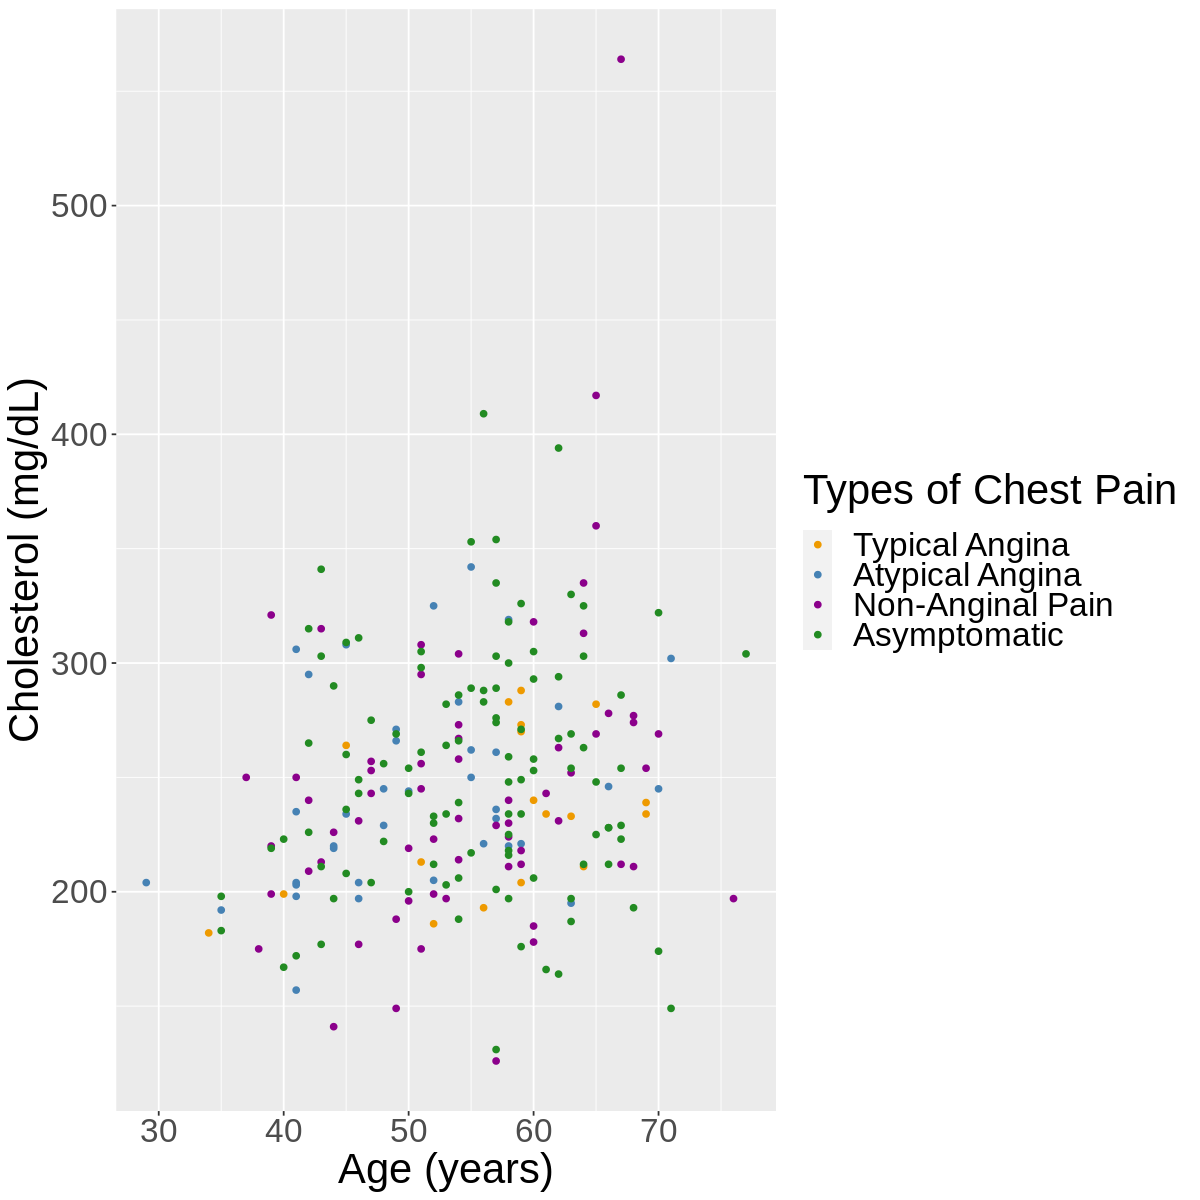

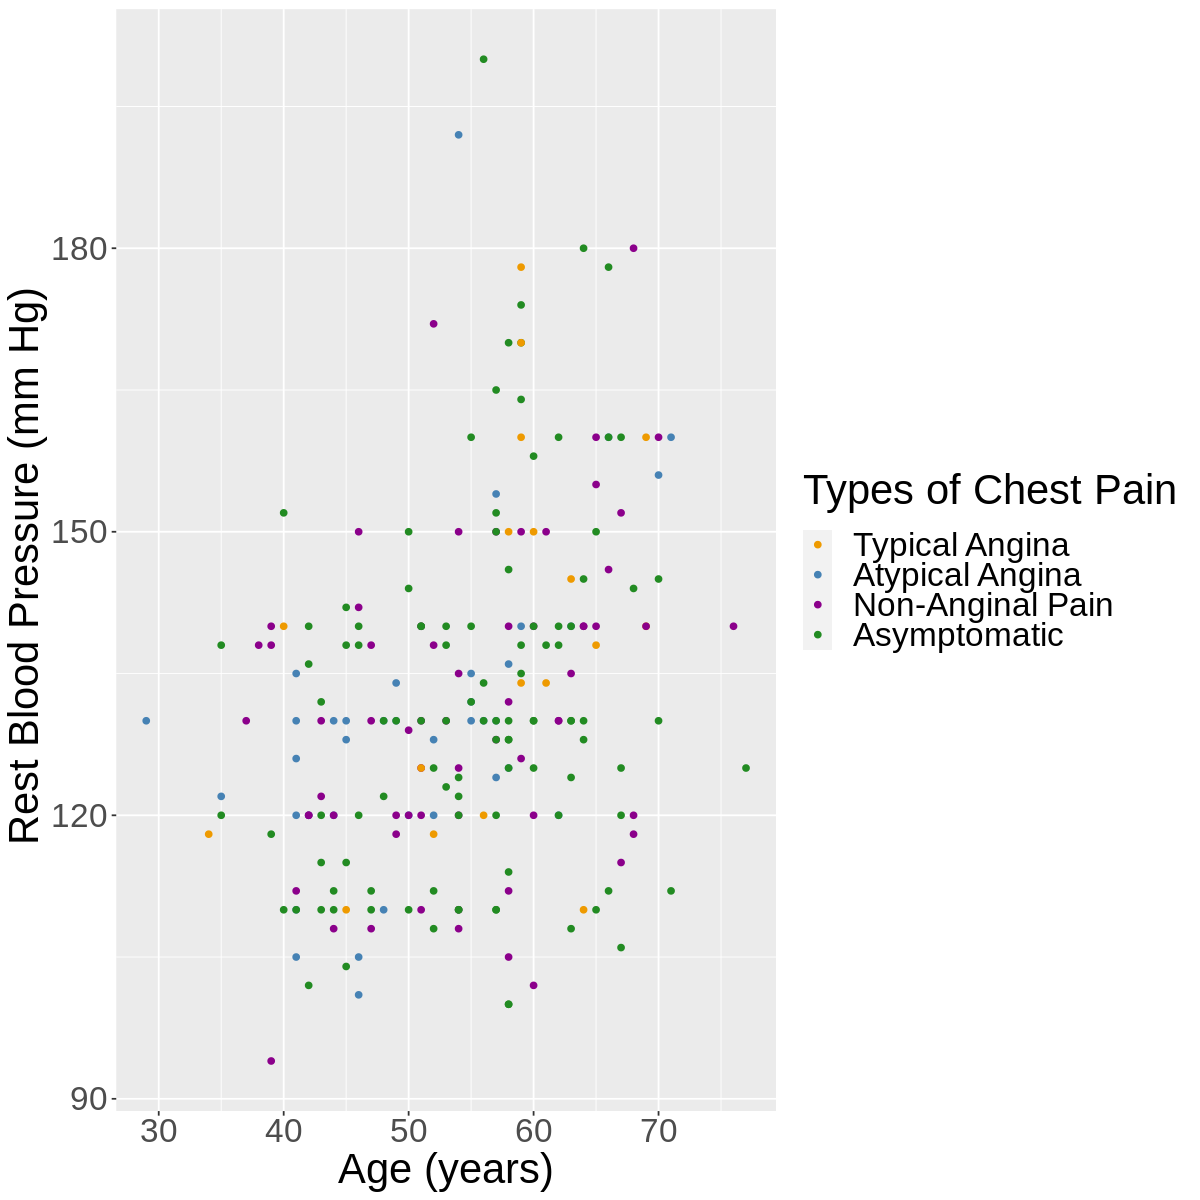

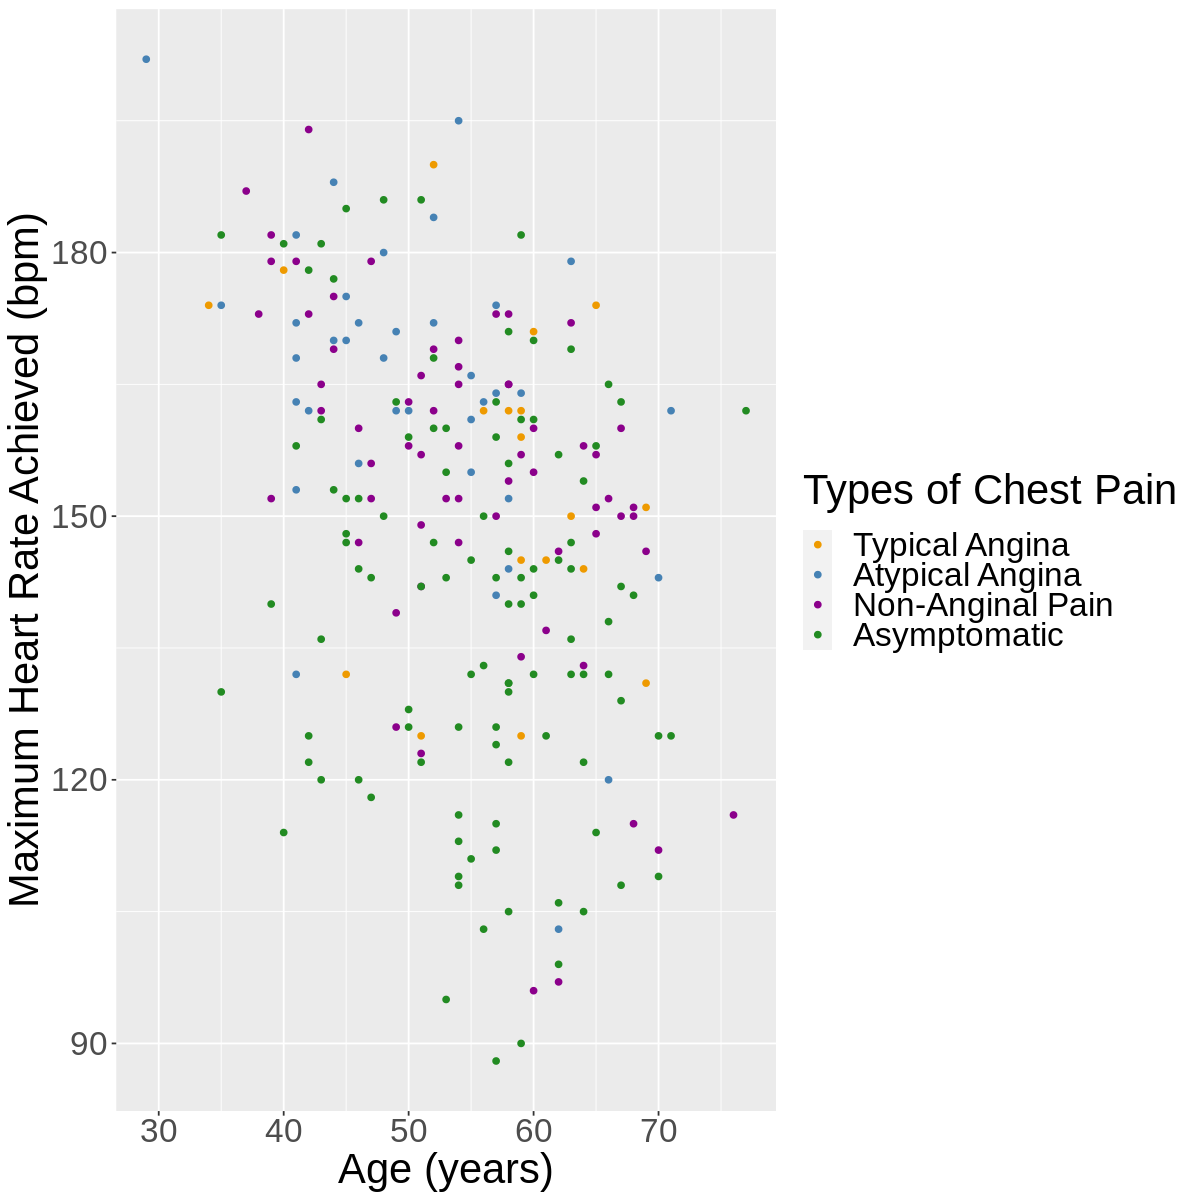

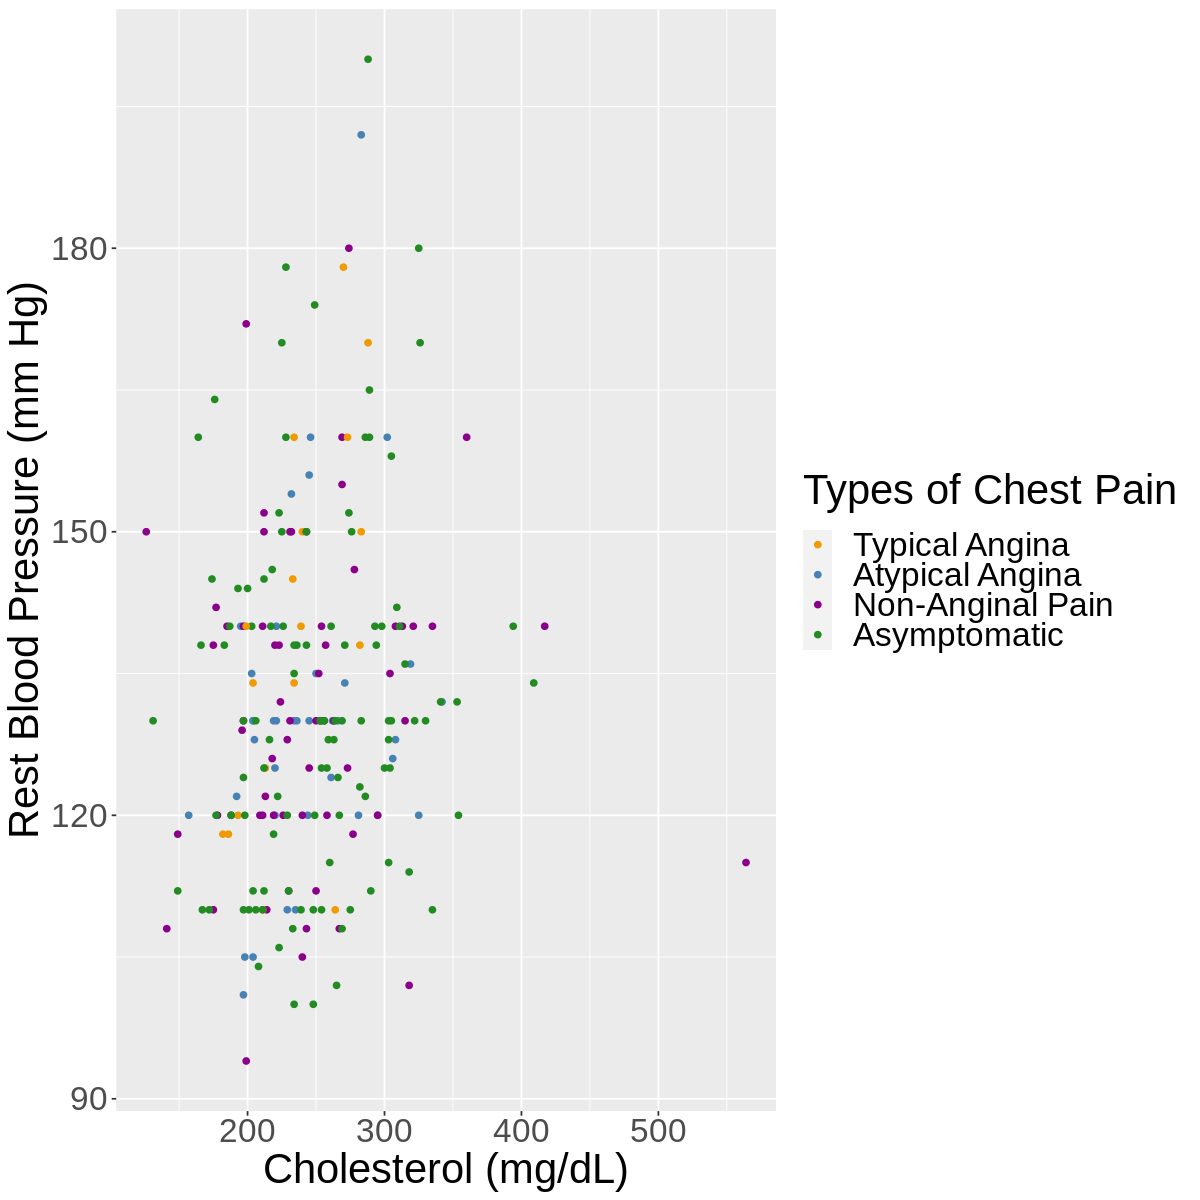

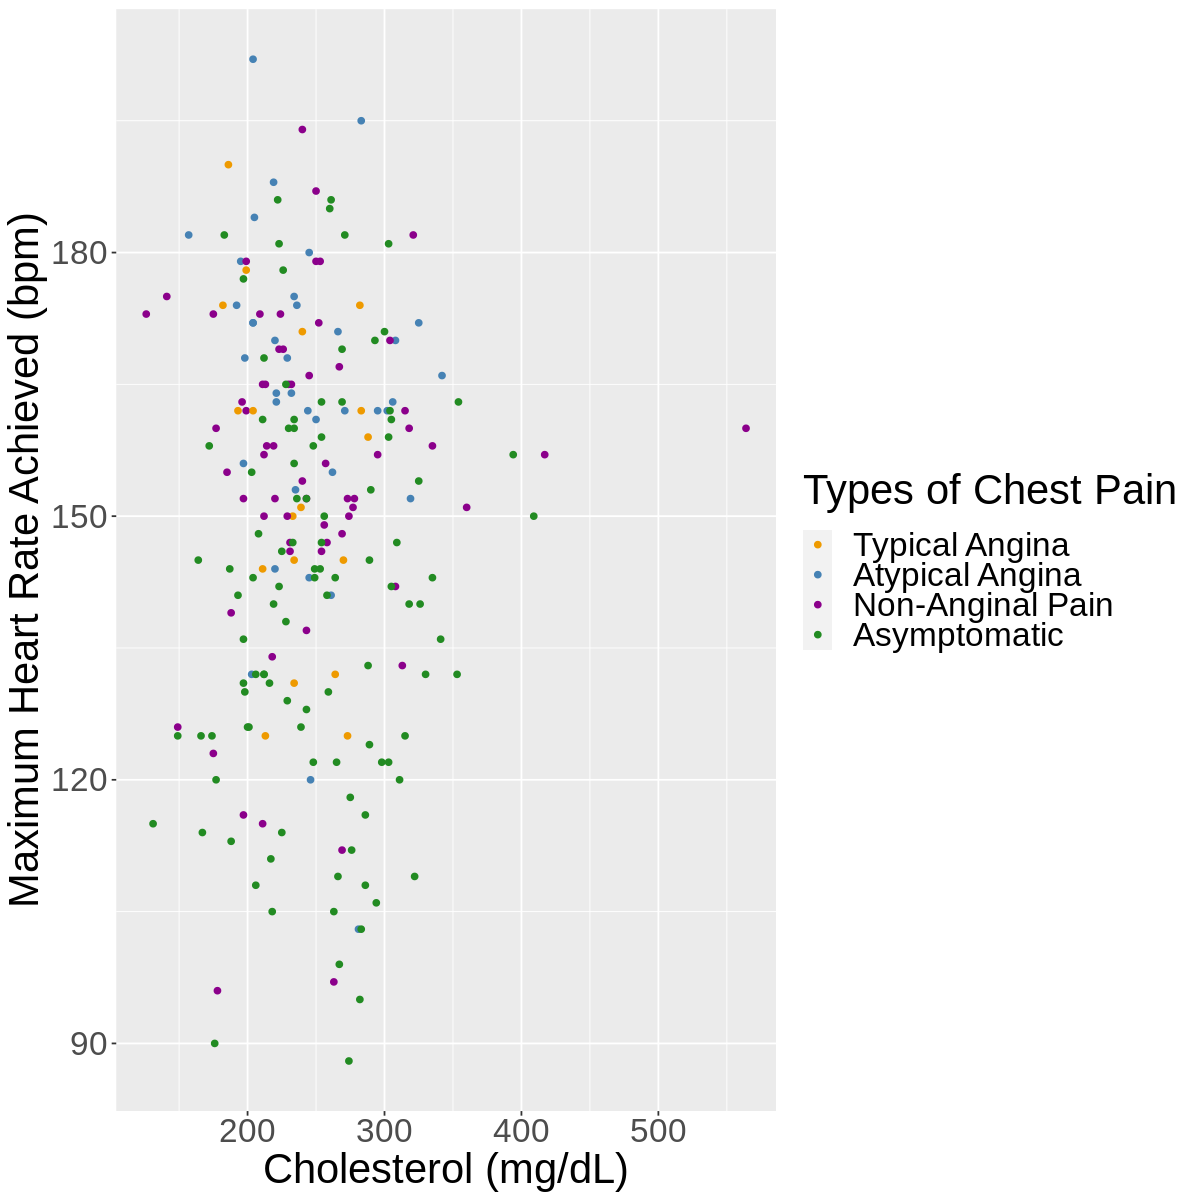

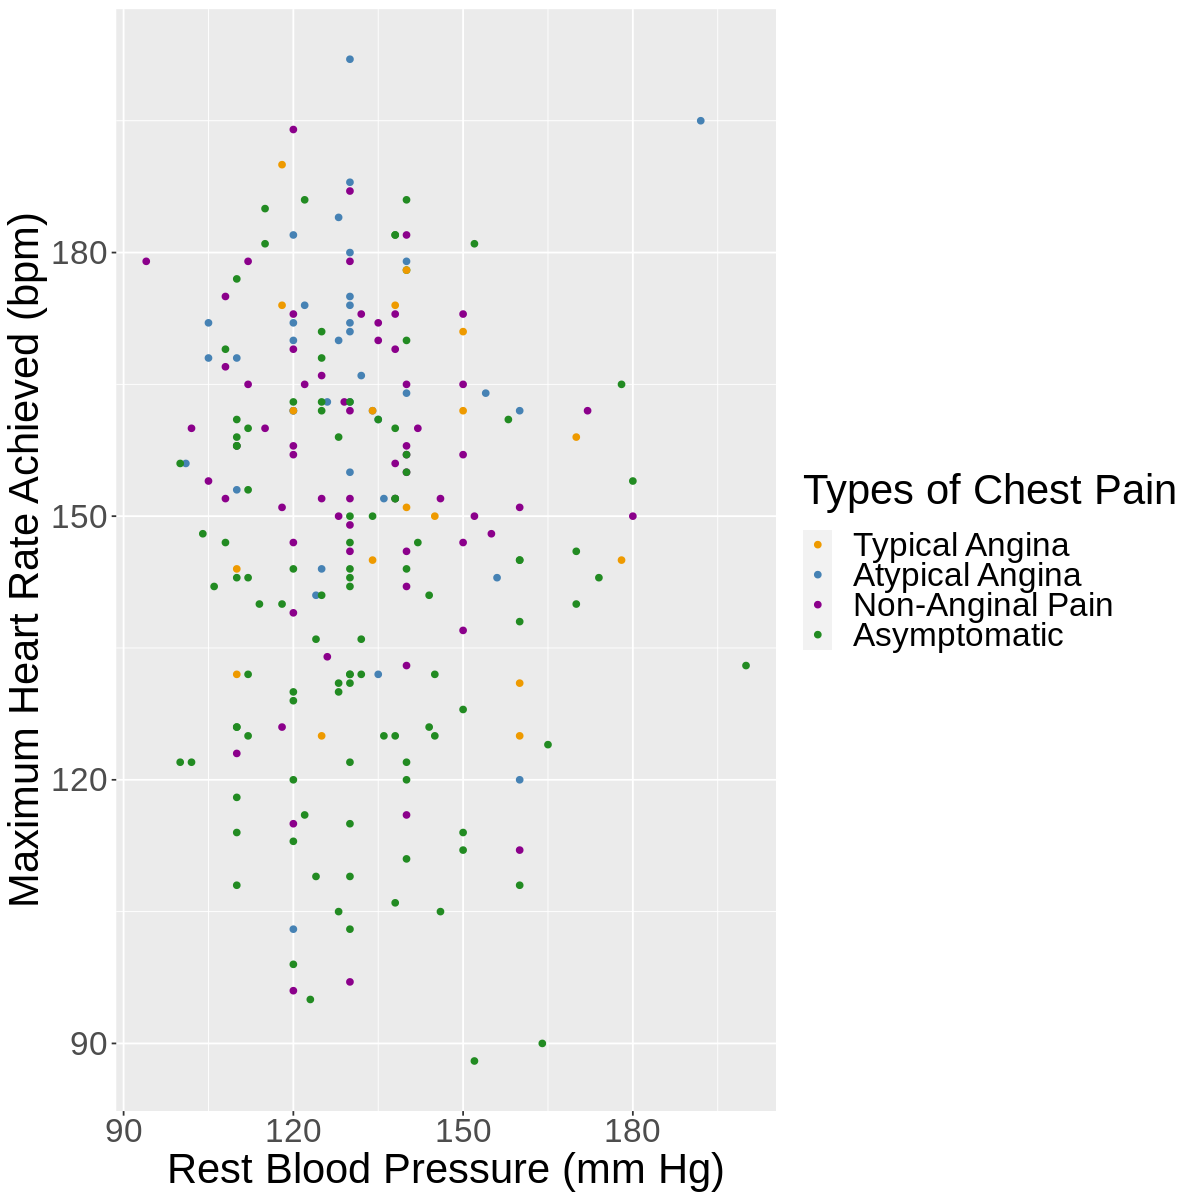

In [31]:
# All visualizations
age_choles
age_bp
age_hr
choles_bp
choles_hr
bp_hr

### Methods

Classification is the method of predicting which category a new observation falls into depending on it's other variables. For our project, we will be analysing data using the method of classification. Classification will be a useful methodology as our data can be labelled under different labels according to certain variables in input, and then the labels can be projected for the data.
There are 14 different variables in the cleveland_data set which can help to determine and analyize different diseases in cleveland effectively. However, we will not be using all the columns/variables available in the dataset. We believe that a type of chest pain caused to a person depend on different factors and therefore, we want to use different variables to get a much more accurate analysis. The required variables/columns used in our data analysis will be as follows:
- Predictors: Age (years), Serum cholesterol levels (mg/dl), Rest Blood Pressure (mm Hg) and Maximum Heart Rate Achieved (bpm)
              
- Category to predict: Type of Chest Pain (eg: 1, 2, 3, 4)

We will be plotting the data using different scatter plots by plotting diiferent predictors together into six separate scatter plots and finally combining them all to do an analaysis of all the predictors against type of chest pain.


### Expected Outcomes and Significance

We are expecting to find the relationship between all the predictors and the type of chest pain a person may have. We can find whether this relationship will be a weak or strong relationship, a positive or negative relationship, and a linear or not linear relationship. We can also find the different types/levels of chest pain based on the variables. If we predict a value of 1 in an analysis it corresponds to typical angina, a value of 2 corresponds to atypical angina, a value of 3 corresponds to nonanginal pain, and a value of 4 corresponds to asymptomatic. 
The impact of these findings could help doctors predict which patients are at a higher risk for heart attacks and strokes. Cholesterol, age, Resting Blood Pressure and Maxium Heart Rate Achieved are quick and easily measurable factors. If heart attack and stroke risk can be determined from these factors, doctors can help their patients implement preventative measures prior to the health incidents' occurring. 
A possible future question for our data exploration is finding the levels of cholesterol to predict the different type of chest pain. For example, a question could be: “what are the levels of cholesterol in the blood seen in patients diagnosed with typical angina?”. Another future question is discovering the age groups or ranges that are at risk fof the different types of chest pain. For example, a question could be: “what are the age groups that are most at risk for atypical angina?” and many more as we compare with different variables.

We believe our data analysis of cleveland_data will contribute as it can help understand a prime question much better and help understand the severity of chest pains more effectively.